In this project, we will work with the medical mnist datasource, specifically the pneumonia dataset from https://medmnist.com/ . The problem consists of classifying chest x-ray images as having pneumonia or not. Run the below lines of code to install the appropriate dataloaders and visualize the data

In [ ]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms


*** Challenge 1***

Here the goal is to train on 10 samples on the pneumonia mnist data. In this preliminary testbed, the evaluation will be done on a 1000 sample randomly sampled development set. Note in the end the final evaluation will be done on the full Pneumoniamnist test set as well as potentially a separate dataset. The development set samples here thus should not be used for training in any way, the final evaluation will provide only 10 random samples of the same distribution and as well to evaluate the generality of your algorithm from a data source that is not the Pneumoniamnist training data. 

Feel free to modify this testbed to your liking, including the normalization transformations, etc. Note, however, the final evaluation testbed will have a rigid set of components where you will need to place your answer. The only constraint is the data. Refer to the full project instructions for more information.


Below we set up training functions. Again you are free to fully modify this testbed in your prototyping within the constraints of the data used. You can use tools outside of PyTorch for training models if desired as well although the torchvision dataloaders will still be useful for interacting with the Pneumoniamnist dataset. 

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(1, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*4*4, 1)
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*4*4)
        x = self.fc(x)
        return x

In [ ]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

def resNet34():
    resNet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
    resNet34.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet34.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet34

def resNet50():
    resNet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
    resNet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet50.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet50

def resNet101():
    resNet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=False)
    resNet101.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet101.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet101

def resNet152():
    resNet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=False)
    resNet152.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet152.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet152

The below tries 5 random problem instances. Due to the small sample size, the variance of this problem is quite high. Run several instances of the problem to reduce the variance.

In [ ]:
!pip install -qqq medmnist

In [ ]:
resNets = [resNet18, resNet34, resNet50, resNet101, resNet152]

In [ ]:
%%time
from random import randint

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

loss18_val = []
loss34_val = []
loss50_val = []
loss101_val = []
loss152_val = []
accs_val = []
seed = randint(0,50)

for resNet in resNets:
    if resNet is resNet18:
        print("ResNet18: ")
    elif resNet is resNet34:
        print("ResNet34: ")
    elif resNet is resNet50:
        print("ResNet50: ")
    elif resNet is resNet101:
        print("ResNet101: ")
    elif resNet is resNet152:
        print("ResNet152: ")
    # for seed in  range(0, 50):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    train_top = 10//n_classes
    val_top = 1000//n_classes
    indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
    indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

    train_data = Subset(train_dataset, indx_train)
    val_data = Subset(val_dataset, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=32, 
                                                shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                                batch_size=128, 
                                                shuffle=False)

    model = resNet()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    for epoch in range(50):
        l = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
        if resNet is resNet18:
            loss18_val.append(l)
        elif resNet is resNet34:
            loss34_val.append(l)
        elif resNet is resNet50:
            loss50_val.append(l)
        elif resNet is resNet101:
            loss101_val.append(l)
        elif resNet is resNet152:
            loss152_val.append(l)

    accs_val.append(test(model, device, val_loader))

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
ResNet18: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.879212
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000399
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000176
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000089
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000057
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000044
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000038
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000033
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000029
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000026


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 1.7966, Accuracy: 705/1000 (70.50%)

ResNet34: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.850187
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000283
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000105
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000034
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000014
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000012
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000011
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000011

Val set: Average loss: 3.1246, Accuracy: 578/1000 (57.80%)

ResNet50: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.577780
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000110
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000008
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000015
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000003
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000004
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000004
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000004
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000004
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000004

Val set: Average loss: 3.7184, Accuracy: 631/1000 (63.10%)

ResNet101: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.728630
Train Epoch: 5 [0/10 (0%)]	Loss: 0.408966
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000222
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000052
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000064
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000035
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000012

Val set: Average loss: 1.9909, Accuracy: 653/1000 (65.30%)

ResNet152: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.882309
Train Epoch: 5 [0/10 (0%)]	Loss: 0.024508
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000248
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000147
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000081
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000037
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000029
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000023
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000019
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000018

Val set: Average loss: 3.8103, Accuracy: 627/1000 (62.70%)

CPU times: user 4min 44s, sys: 20.6 s, total: 5min 5s
Wall time: 5min 11s


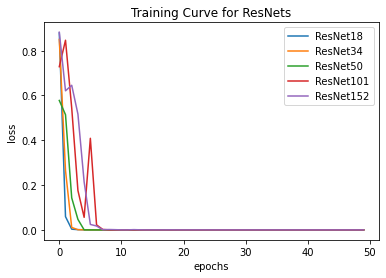

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss18_val, label="ResNet18")
plt.plot(loss34_val, label="ResNet34")
plt.plot(loss50_val, label="ResNet50")
plt.plot(loss101_val, label="ResNet101")
plt.plot(loss152_val, label="ResNet152")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training Curve for ResNets');
plt.savefig('untrainedresnets_training.png')

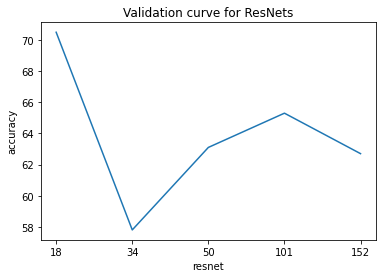

In [ ]:
import matplotlib.pyplot as plt

x = ['18', '34', '50', '101', '152']
plt.plot(x , accs_val)
plt.xlabel('resnet')
plt.ylabel('accuracy')
plt.title('Validation curve for ResNets');
plt.savefig('untrainedresnets_validation.png')